In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

# Problem 1

In [24]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    #create a linspace to integrate over using apporximation
    data = np.linspace(0,1,1000)
    
    #simulate coin tosses
    coin_tosses= np.random.binomial(n,p)
    
    #sum over integral and divide, use coin_tosses
    post = [binom.pmf(coin_tosses,n,_p) for _p in data]
    sum_of_post = sum(post)
    
    plt.plot(data, post)
    plt.title(f"PMF with {n} coin tosses")
    plt.show()
    
    #return MLE
    return data[np.argmax(post/sum_of_post)], max(post)

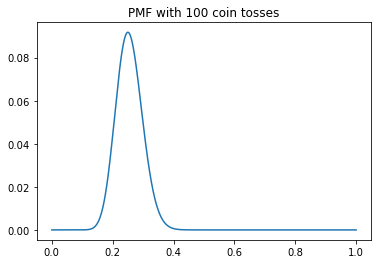

(0.2502502502502503, 0.09179815940162318)


In [25]:
print(bernoulli_sampling(.2,100))

# Problem 2

In [35]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    #create a linspace to integrate over using apporximation
    data = np.linspace(0,1,1000)
    
    #simulate coin tosses
    coin_tosses= np.random.binomial(n,p)
    prob_p = prior.pdf(data)
    
    #sum over integral and divide, use coin_tosses, multiply by passed in prior
    post = [binom.pmf(coin_tosses,n,_p) for _p in data]*prob_p
    sum_of_post = sum(post)
    
    plt.plot(data, post, label= "posterior")
    plt.plot(data, prob_p, label = "prior")
    plt.title(f"PMF with {n} coin tosses")
    plt.legend()
    plt.show()
    
    #return MLE
    return data[np.argmax(post/sum_of_post)], max(post)

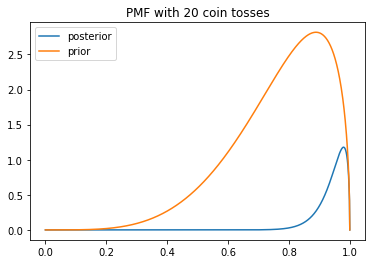

(0.97997997997998, 1.1787139223134644)


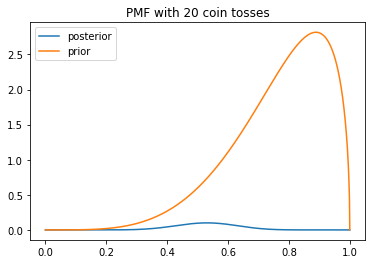

(0.5305305305305306, 0.10032026578644708)


In [36]:
print(non_uniform_prior(.9,20,beta(5,1.5)))
print(non_uniform_prior(.4,20,beta(5,1.5)))

# Problem 3

In [37]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    #inherit from markovchain lab, figure out walk 
    from markov_chains import MarkovChain
    chain = MarkovChain(transition_matrix, states = ["sun","rain","wind"])
    
    #call walk from markov chains
    return chain.walk("sun", days)
    

In [38]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)
print(weather_forecast(transition_matrix.T, days=10))

['sun', 'sun', 'sun', 'sun', 'sun', 'wind', 'sun', 'sun', 'wind', 'sun']


# Problem 4

In [42]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    
    model = pm.Model()
    with model:
        #set theta as prior distribution
        theta = pm.Beta('theta', alpha=1, beta=1)
        
        #establish y
        y = pm.Bernoulli('y', p=theta, observed=data)
        
        trace = pm.sample(n) #n is the desired number of samples
        az.plot_trace(trace)
        theta = trace['theta']
        
        #calculate mean
        mean = theta.mean()
        
    return mean

/var/folders/lr/fg5wjmh12v98hyb8l27lypk00000gn/T/ipykernel_90258/1013338014.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #n is the desired number of samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


0.1892575363487273

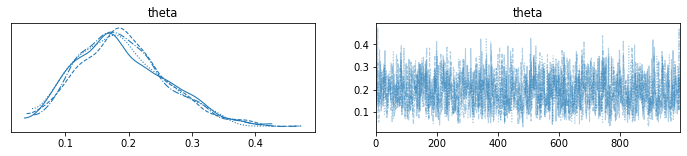

In [43]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data)

# Problem 5

In [44]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    
    model = pm.Model()
    with model:
        #set mu and tau as prior distributions
        mu = pm.Normal('mu', mu=m, sd=s)
        tau = pm.Gamma('tau', alpha=alpha, beta=beta)
        
        #establish y as normal with two priors
        y = pm.Normal('y', mu=mu,sd=1/tau, observed=observed_heights)
        
        trace = pm.sample(n) #n is the desired number of samples
        az.plot_trace(trace)
        mu = trace['mu']
        
        #calculate mean
        mean = mu.mean()
        
    return mean

/var/folders/lr/fg5wjmh12v98hyb8l27lypk00000gn/T/ipykernel_90258/4154067257.py:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #n is the desired number of samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


178.83528655661206


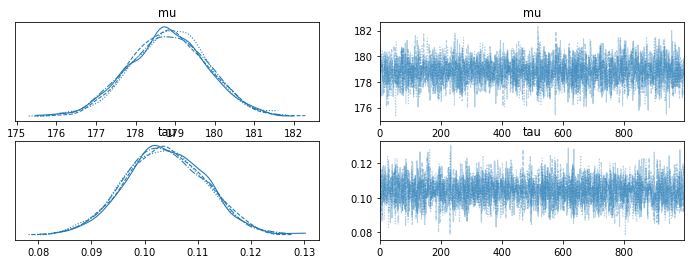

In [45]:
heights = np.random.normal(180,10,100)
print(height_model(heights))